This notebook demonstrates Kausal framework on Coupled Rossler dynamics.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import coupled_rossler
from kausal.koopman import Kausal
from kausal import stats


# 1. Generate dynamics 
First, we are going to generate the dynamics of Coupled Rossler as described in https://arxiv.org/pdf/2410.10103.
Some analysis are then performed, including reproducing Figure 1b.

### 1a. Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = torch.tensor([1.0, -2.0, 0.0, 0.0, 0.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0


### 1b. Integrate forward

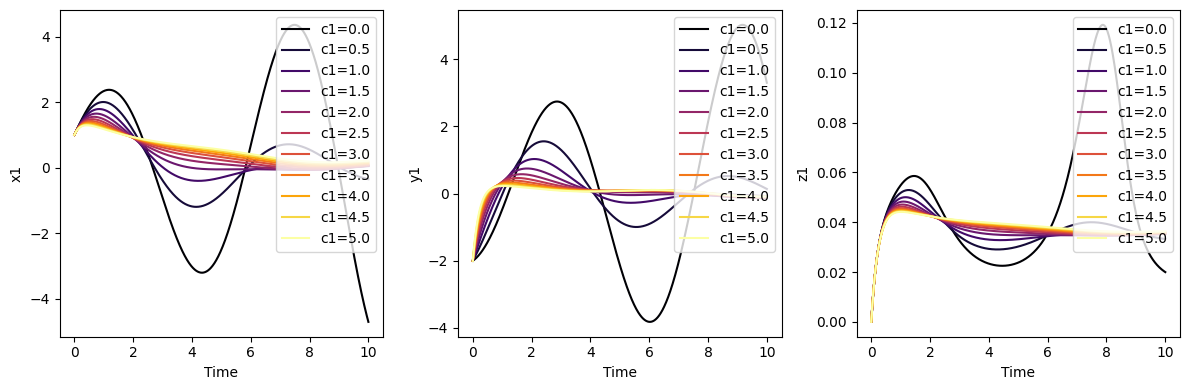

In [4]:
# Integration
solver = torchdiffeq.odeint

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = torch.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(np.linspace(0, 1, len(c1_values)))  # Inferno colormap

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: coupled_rossler(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

# Iterate over coupling values and solve the system
for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

    # Extract results (divided into omega_1, omega_2)
    omega_1 = solution.T[:3]
    omega_2 = solution.T[3:]

    # Plot the results
    ax[0].plot(t.numpy(), omega_1[0].numpy(), label=f"c1={c1:.1f}", color=color)
    ax[1].plot(t.numpy(), omega_1[1].numpy(), label=f"c1={c1:.1f}", color=color)
    ax[2].plot(t.numpy(), omega_1[2].numpy(), label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show();


# 2. Causal Koopman

This section describes several causal algorithms based on Koopman operator framework, as described in https://arxiv.org/pdf/2410.10103. In particular, there are two causal effect analyses that we are interested in:

1. __Temporal shifts__: estimate causal effect by increasing temporal dependency (shift). 
2. __Conditional forecast__: estimate causal effect by estimating the conditional forecasts between marginal and joint models.

In [5]:
# Let's first generate the dynamics
t0, t1 = 0.0, 40.0
dt = 0.01
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters
c1, c2 = 0.5, 0 # Coupling term
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results (divided into omega_1, omega_2)
omega_1 = solution.T[:3] # True effect variables
omega_2 = solution.T[3:] # True cause variables


### 2a. Causal dependence with increasing shifts

Expected behaviors:
1. __True causal relationship__: Increasing causal 'error' between the marginal and joint models.
2. __False causal relationship__: Low, stationary causal 'error' between the marginal and joint models.

Here, we evaluate the temporal dependency analysis, primarily to reproduce Figure 2.

In [6]:
# Initialize Kausal object, where we can pass in the cause-effect variables to be analyzed

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    cause = omega_1,
    effect = omega_2
)


In [7]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


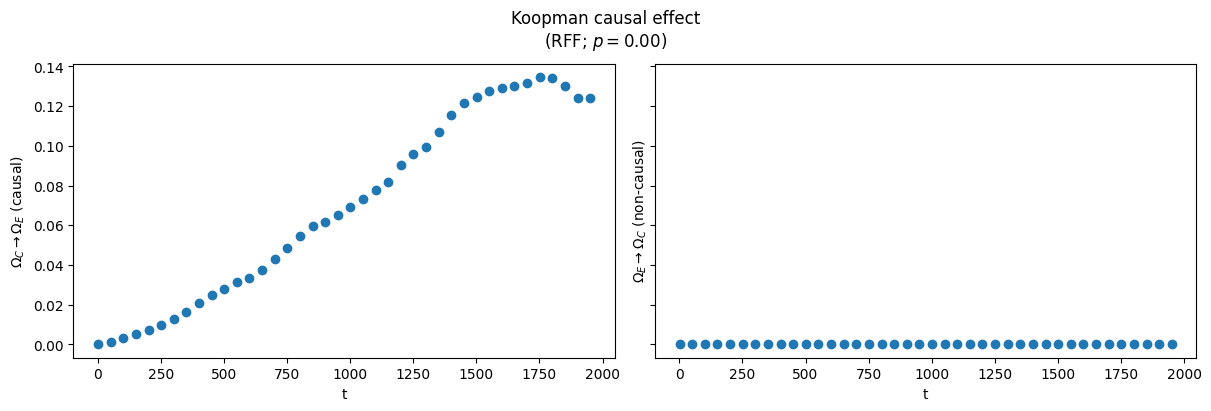

In [8]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(RFF; $p = {pval:.2f}$)')
plt.show();


### 2b. Conditional forecast
This is primarily to reproduce the algorithms introduced in Part IV section B, and Figure 4.

Expected behaviors:
1. __True causal relationship__: imperfect match in the marginal model, but better in the joint model since the former lacks the key causal variables.
2. __False causal relationship__: perfect match in the marginal and joint models, since the 'false causal' variables are not useful to make skillful forecast.

In [9]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in the joint model.
cause = omega_2
effect = omega_1

omega_marginal, omega_joint = causal_koopman.forecast(
    n_train = n_train,
    time_shift = 1
)


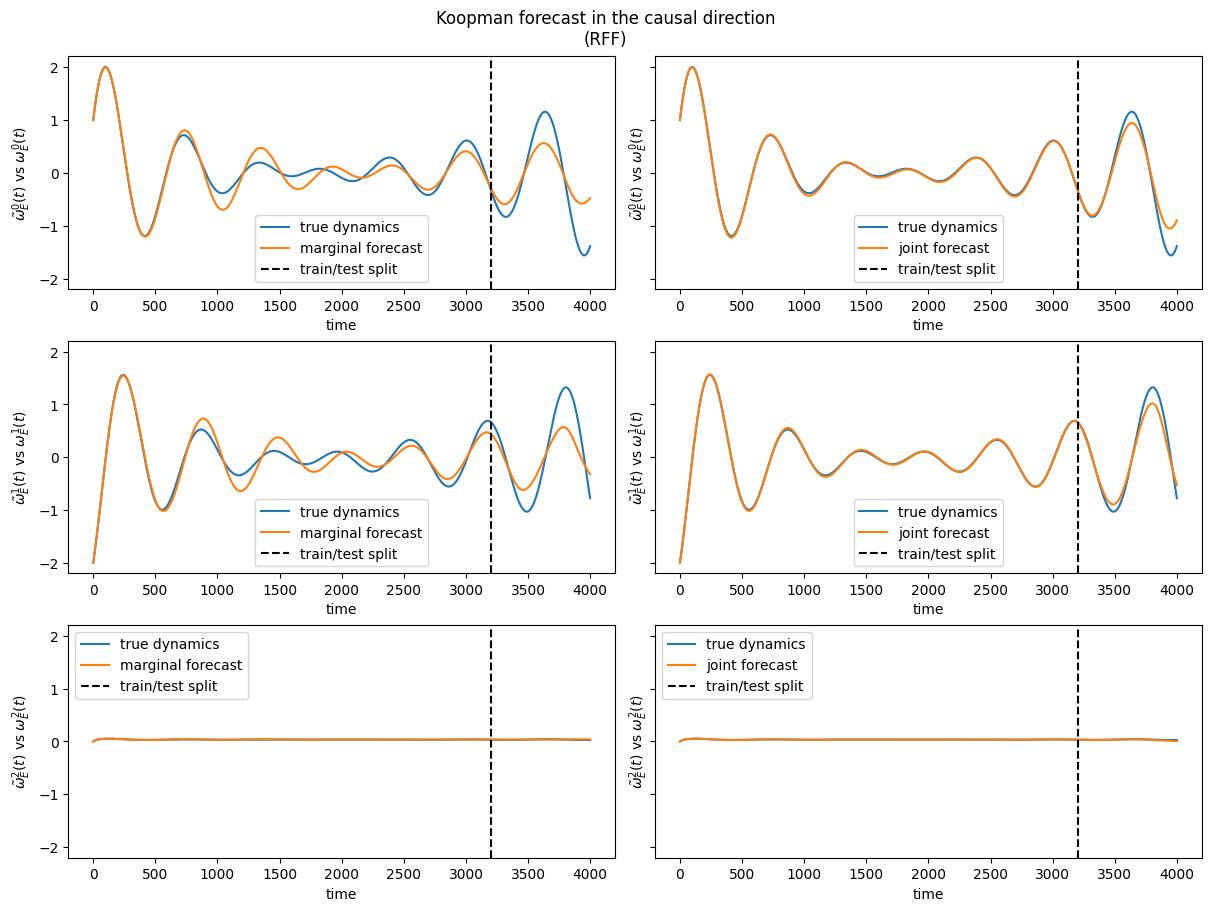

In [10]:
# Plot (conditional inference: causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(RFF)')
plt.show();


In [11]:
# Conditional inference (non-causal)
# Expected behavior: better match in both the marginal and joint models.
cause = omega_1
effect = omega_2

omega_marginal, omega_joint = noncausal_koopman.forecast(
    n_train = n_train,
    time_shift = 1
)


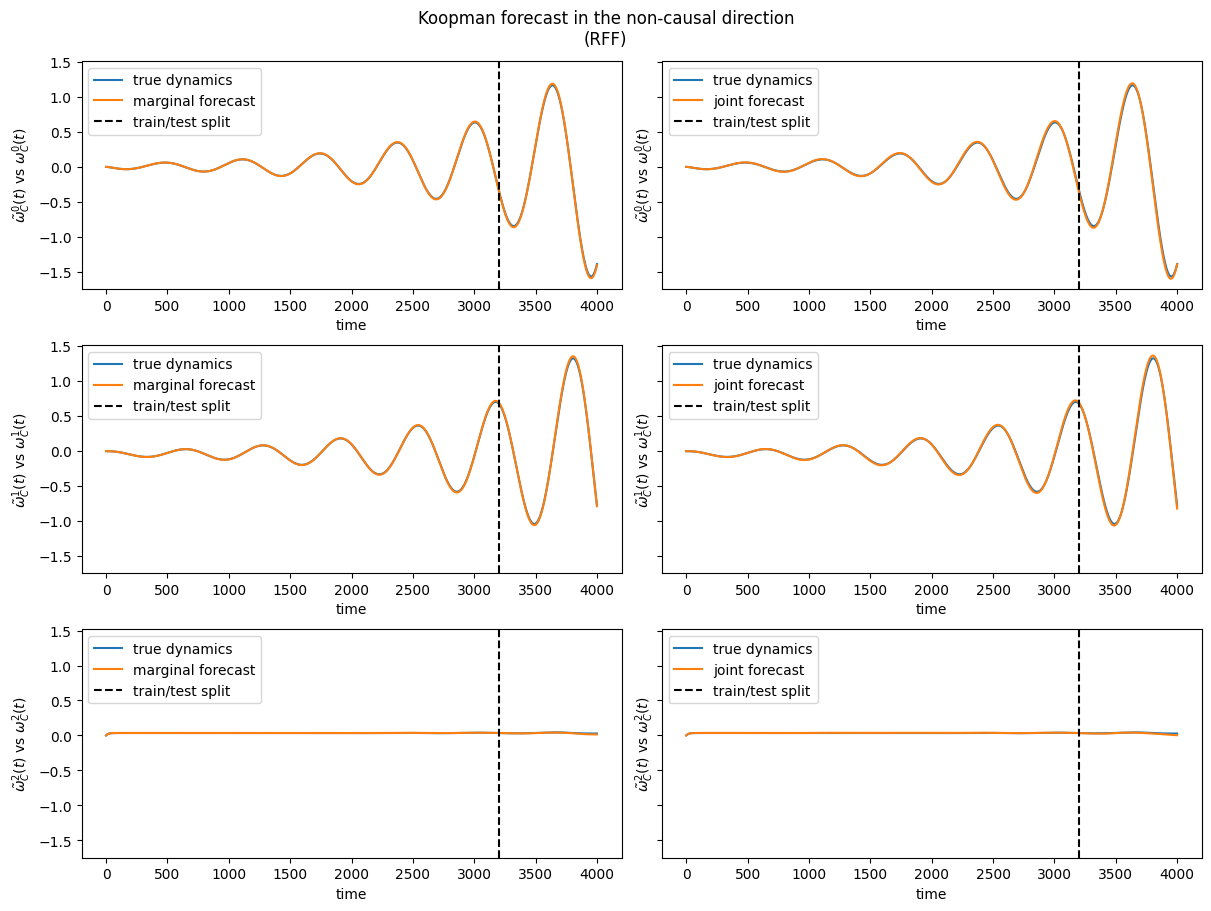

In [12]:
# Plot (conditional inference: non-causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(RFF)')
plt.show();


# 3. Deep Causal Koopman
Now, we use neural network (encoder-decoder __MLP__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables. We perform similar causal analysis as above!

In [13]:
# Initialize Kausal object, where we now specify DL-based observable functions.
from kausal.observables import MLPFeatures

# Specify hyperparameters
hidden_channels = [16, 32]

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    marginal_observable = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3),
    joint_observable = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3),
    cause = omega_1,
    effect = omega_2
)


In [14]:
# We first have to fit/train the observable functions
lr = 1e-2
epochs = 500

# 1. Causal direction
marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)

# 2. Non-causal direction
marginal_loss_ec, joint_loss_ec = noncausal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = n_train
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.40it/s]


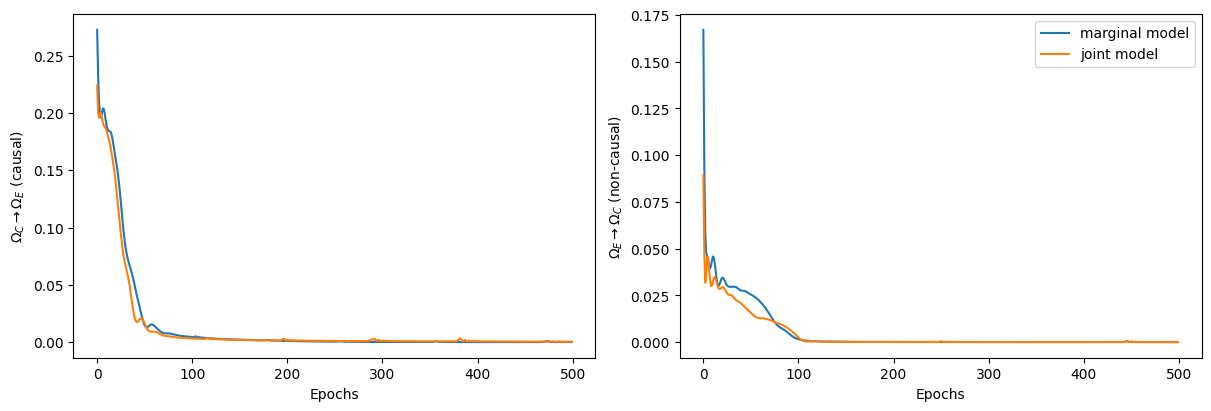

In [15]:
# Plot training losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

plt.legend()
plt.show();


### 3a. Causal dependence with increasing shifts

In [16]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.92it/s]


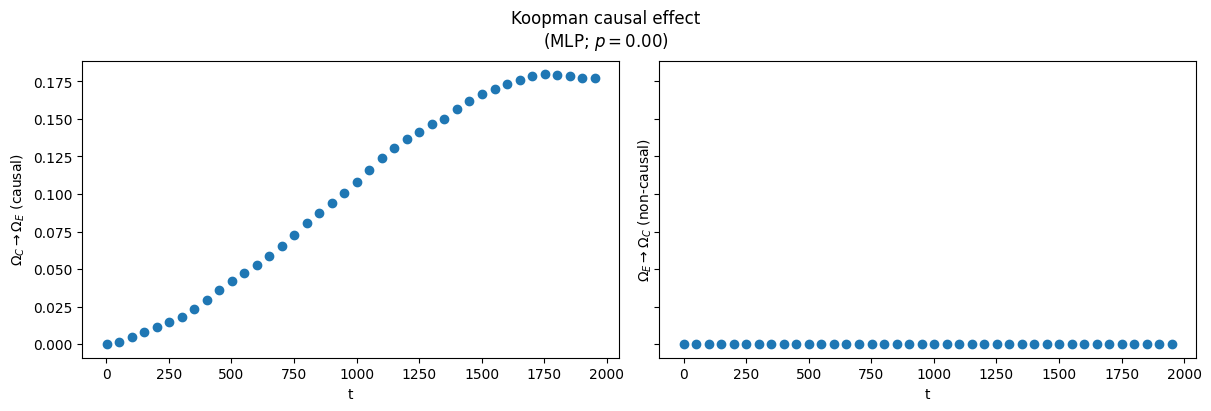

In [17]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(MLP; $p = {pval:.2f}$)')
plt.show();


### 3b. Conditioning forecasting

In [18]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but better in joint.
cause = omega_2
effect = omega_1

with torch.no_grad():
    omega_marginal, omega_joint = causal_koopman.forecast(
        n_train = n_train,
        time_shift = 1
    )


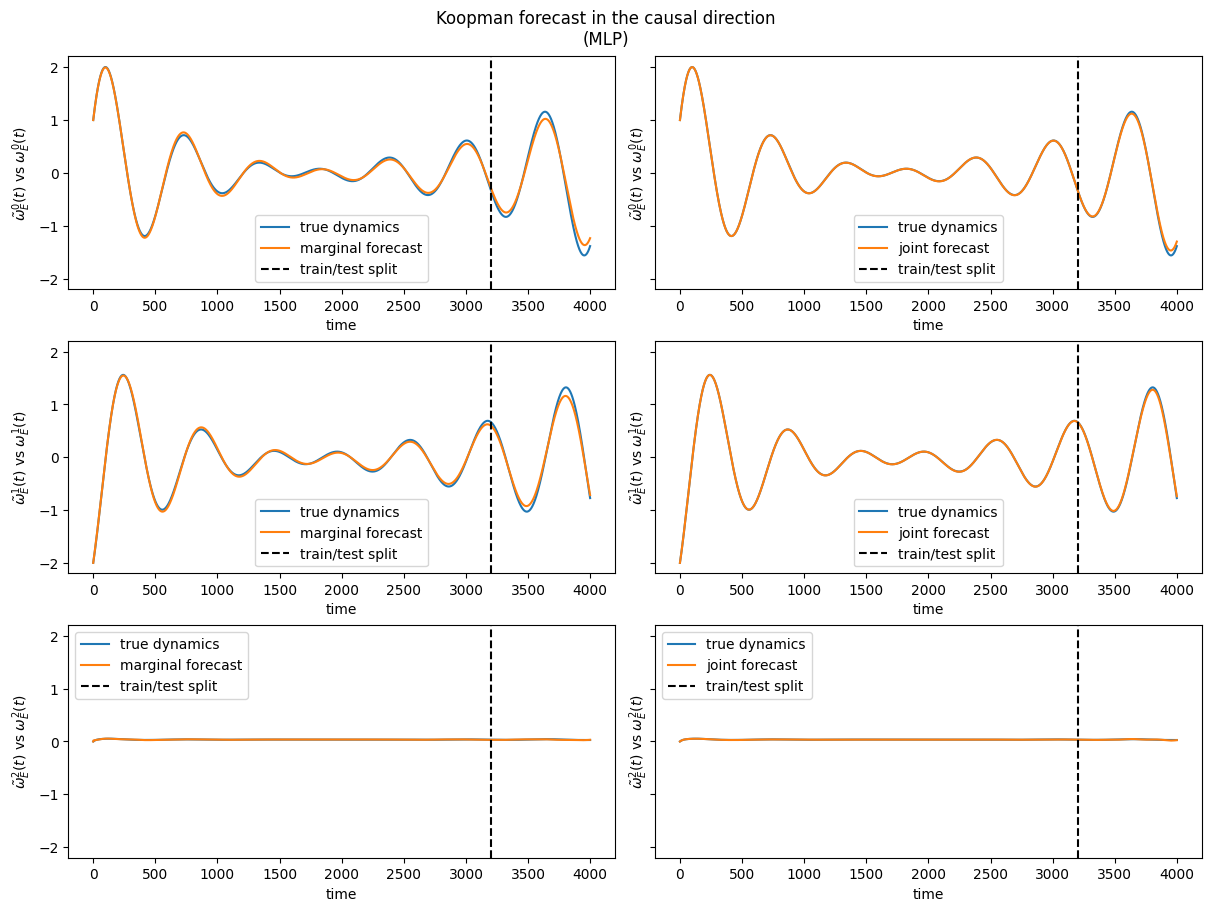

In [19]:
# Plot (conditional inference: causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(MLP)')
plt.show();


In [20]:
# Conditional inference (non-causal)
# Expected behavior: better match in both marginal and joint models.
cause = omega_1
effect = omega_2

with torch.no_grad():
    omega_marginal, omega_joint = noncausal_koopman.forecast(
        n_train = n_train,
        time_shift = 1
    )


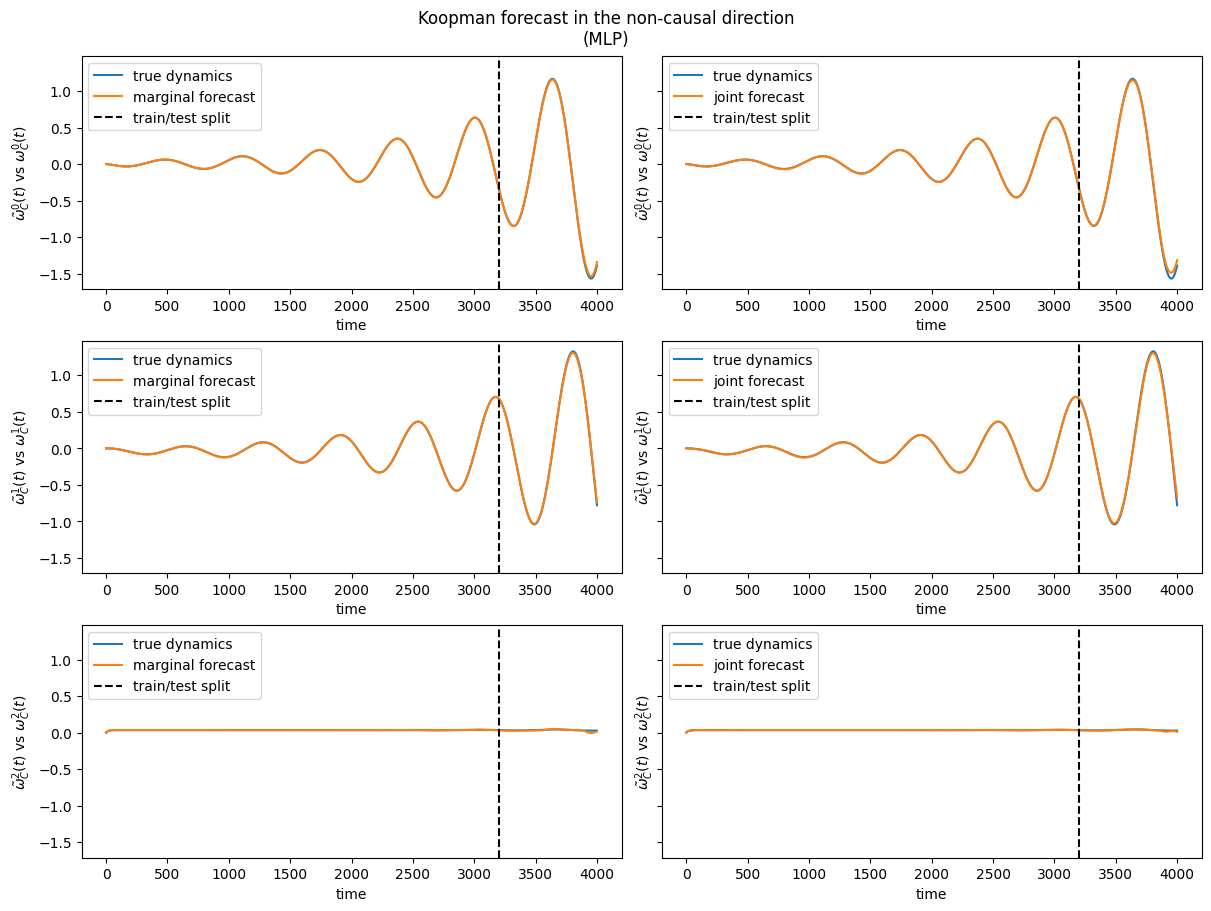

In [21]:
# Plot (conditional inference: non-causal)
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(MLP)')
plt.show();
